# **Structure of AES**

Para lograr una permutación con clave que no sea factible de invertir sin la clave, AES aplica una gran cantidad de operaciones de mezcla ad hoc en la entrada. Esto contrasta marcadamente con los criptosistemas de clave pública como RSA, que se basan en elegantes problemas matemáticos individuales. AES es mucho menos elegante, pero es muy rápido.

En un nivel alto, AES-128 comienza con un "programa clave" y luego ejecuta 10 rondas sobre un estado. El estado inicial es simplemente el bloque de texto plano que queremos cifrar, representado como una matriz de bytes de 4x4. A lo largo de las 10 rondas, el estado se modifica repetidamente mediante una serie de transformaciones reversibles.

Cada paso de transformación tiene un propósito definido basado en las propiedades teóricas de los cifrados seguros establecidos por Claude Shannon en la década de 1940. Examinaremos más de cerca cada uno de estos en los siguientes desafíos.


A continuación se ofrece una descripción general de las fases del cifrado AES:

diagrama que muestra rondas AES

1. KeyExpansion o Key Schedule

 De la clave de 128 bits, se derivan 11 "claves redondas" separadas de 128 bits: una que se utilizará en cada paso AddRoundKey.

2. Adición de clave inicial

 AddRoundKey : los bytes de la clave de primera ronda se XOR con los bytes del estado.

3. Ronda : esta fase se repite 10 veces, durante 9 rondas principales más una "ronda final"

 a) SubBytes : cada byte del estado se sustituye por un byte diferente según una tabla de búsqueda ("S-box").

 b) ShiftRows : las últimas tres filas de la matriz de estado se transponen (se desplazan sobre una columna, dos o tres).

 c) MixColumns : la multiplicación de matrices se realiza en las columnas del estado, combinando los cuatro bytes en cada columna. Esto se omite en la ronda final.

 d) AddRoundKey : los bytes de la clave de ronda actual se XOR con los bytes del estado.

Se incluye una bytes2matrixfunción para convertir nuestro bloque de texto plano inicial en una matriz de estado. Escriba una matrix2bytesfunción para convertir esa matriz nuevamente en bytes y envíe el texto sin formato resultante como bandera.

In [ ]:
def bytes2matrix(text):
    return [list(text[i:i+4]) for i in range(0, len(text), 4)]

def matrix2bytes(matrix):
    text = ''
    for i in range(len(matrix)):
        for j in range(4):
            text += chr(matrix[i][j])
    return text

matrix = [
    [99, 114, 121, 112],
    [116, 111, 123, 105],
    [110, 109, 97, 116],
    [114, 105, 120, 125],
]

print(matrix2bytes(matrix))

crypto{inmatrix}



  # **Round Keys**

Por ahora, nos saltaremos los detalles más finos de la fase KeyExpansion . El punto principal es que toma nuestra clave de 16 bytes y produce 11 matrices de 4x4 llamadas "claves redondas" derivadas de nuestra clave inicial. Estas claves redondas permiten a AES aprovechar más la clave única que proporcionamos.

La fase inicial de adición de claves , que es la siguiente, tiene un único paso AddRoundKey . El paso AddRoundKey es sencillo: aplica XOR al estado actual con la clave de ronda actual.

diagrama que muestra AddRoundKey

AddRoundKey también ocurre como el paso final de cada ronda. AddRoundKey es lo que hace que AES sea una "permutación con clave" en lugar de simplemente una permutación. Es la única parte de AES donde la clave se mezcla con el estado, pero es crucial para determinar la permutación que ocurre.

Como ha visto en desafíos anteriores, XOR es una operación fácilmente reversible si conoce la clave, pero difícil de deshacer si no la conoce. Ahora imagine intentar recuperar texto sin formato que ha sido sometido a XOR con 11 claves diferentes y muy mezclado entre cada operación XOR con una serie de cifrados de sustitución y transposición. ¡Eso es lo que hace AES! Y veremos cuán efectiva es la confusión en los próximos desafíos.

Complete la add_round_keyfunción, luego use la matrix2bytesfunción para obtener su próxima bandera.


In [ ]:
import numpy

state = [
    [206, 243, 61, 34],
    [171, 11, 93, 31],
    [16, 200, 91, 108],
    [150, 3, 194, 51],
]

round_key = [
    [173, 129, 68, 82],
    [223, 100, 38, 109],
    [32, 189, 53, 8],
    [253, 48, 187, 78],
]

def add_round_key(s, k):
    return numpy.bitwise_xor(s, k).tolist()

result = add_round_key(state, round_key)

flat_result = [bytes([col]) for row in result for col in row]

text_result = b''.join(flat_result).decode('utf-8')

print(text_result)


crypto{r0undk3y}


# **Confusion through Substitution**

SubBytes . Esto implica tomar cada byte de la matriz de estado y sustituirlo por un byte diferente en una tabla de búsqueda preestablecida de 16x16. La tabla de búsqueda se llama "cuadro de sustitución" o "cuadro S" para abreviar y puede resultar desconcertante a primera vista. Analicémoslo.

diagrama que muestra la sustitución

En 1945, el matemático estadounidense Claude Shannon publicó un artículo innovador sobre la teoría de la información. Identificó la "confusión" como una propiedad esencial de un cifrado seguro. "Confusión" significa que la relación entre el texto cifrado y la clave debe ser lo más compleja posible. Dado solo un texto cifrado, no debería haber forma de saber nada sobre la clave.

Si un cifrado tiene poca confusión, es posible expresar una relación entre texto cifrado, clave y texto sin formato como una función lineal. Por ejemplo, en un cifrado César, ciphertext = plaintext + key. Ésta es una relación obvia, que es fácil de revertir. Se pueden resolver transformaciones lineales más complicadas utilizando técnicas como la eliminación gaussiana. Incluso los polinomios de bajo grado, por ejemplo una ecuación como x^4 + 51x^3 + x, se pueden resolver eficientemente utilizando métodos algebraicos . Sin embargo, cuanto mayor es el grado de un polinomio, generalmente más difícil resulta resolverlo: sólo puede aproximarse mediante una cantidad cada vez mayor de funciones lineales.

El objetivo principal de la S-box es transformar la entrada de una manera que sea resistente a la aproximación mediante funciones lineales. Las S-box apuntan a una alta no linealidad , y aunque la de AES no es perfecta, está bastante cerca. La búsqueda rápida en una S-box es un atajo para realizar una función muy no lineal en los bytes de entrada. Esta función implica tomar el inverso modular en el campo de Galois 2**8 y luego aplicar una transformación afín que ha sido modificada para lograr la máxima confusión. La forma más sencilla de expresar la función es a través del siguiente polinomio de alto grado:

diagrama que muestra la ecuación de S-Box

Para crear el S-box, la función se calculó con todos los valores de entrada de 0x00 a 0xff y las salidas se colocaron en la tabla de búsqueda.

Implemente sub_bytes, envíe la matriz de estado a través del S-box inverso y luego conviértala en bytes para obtener la bandera.

Archivos de desafío:
  - sbox.py

In [ ]:
s_box = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

inv_s_box = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

state = [
    [251, 64, 182, 81],
    [146, 168, 33, 80],
    [199, 159, 195, 24],
    [64, 80, 182, 255],
]


def sub_bytes(s, sbox=s_box):
    return list(map(lambda x: sbox[x], sum(s, [])))

print(bytes(sub_bytes(state, sbox=inv_s_box)))

b'crypto{l1n34rly}'


# **Diffusion through Permutation**

Hemos visto cómo la sustitución de S-box genera confusión. La otra propiedad crucial descrita por Shannon es la "difusión". Esto se relaciona con cómo cada parte de la entrada de un cifrado debe extenderse a cada parte de la salida.

La sustitución por sí sola crea no linealidad, pero no la distribuye en todo el estado. Sin difusión, al mismo byte en la misma posición se le aplicarían las mismas transformaciones en cada ronda. Esto permitiría a los criptoanalistas atacar cada posición de byte en la matriz de estado por separado. Necesitamos alternar sustituciones codificando el estado (de forma invertible) para que las sustituciones aplicadas en un byte influyan en todos los demás bytes del estado. Cada entrada en la siguiente S-box se convierte en una función de varios bytes, lo que significa que con cada ronda la complejidad algebraica del sistema aumenta enormemente.

Una cantidad ideal de difusión provoca que un cambio de un bit en el texto sin formato conduzca a un cambio estadísticamente en la mitad de los bits del texto cifrado. Este resultado deseable se llama efecto Avalancha .


Los pasos ShiftRows y MixColumns se combinan para lograr esto. Trabajan juntos para garantizar que cada byte afecte a todos los demás bytes del estado en solo dos rondas.

ShiftRows es la transformación más simple en AES. Mantiene igual la primera fila de la matriz de estado. La segunda fila se desplaza una columna hacia la izquierda, dando vueltas. La tercera fila se desplaza dos columnas, la cuarta fila tres. Wikipedia lo expresa muy bien: "la importancia de este paso es evitar que las columnas se cifren de forma independiente, en cuyo caso AES degenera en cuatro cifrados de bloque independientes".

diagrama que muestra ShiftRows

El diagrama (y la especificación AES) muestran la ShiftRowsoperación que se produce en notación de columna principal. Sin embargo, el código de muestra siguiente utiliza notación de fila principal para la matriz de estado, ya que es más natural en Python. Siempre que se utilice la misma notación cada vez que se acceda a la matriz, el resultado final será idéntico. Debido a los patrones de acceso y al comportamiento de la caché, el uso de un tipo de notación puede generar un mejor rendimiento.


MixColumns es más complejo. Realiza la multiplicación de matrices en el campo Galois de Rijndael entre las columnas de la matriz de estado y una matriz preestablecida. Por lo tanto, cada byte de cada columna afecta a todos los bytes de la columna resultante. Los detalles de implementación tienen matices; esta página y Wikipedia hacen un buen trabajo cubriéndolos.

diagrama que muestra MixColumns

Proporcionamos código para realizar MixColumns y la operación de avance ShiftRows. Después de implementar inv_shift_rows, tome el estado, ejecútelo inv_mix_columns, luego inv_shift_rowsconviértalo a bytes y tendrá su bandera.

In [ ]:
import numpy as np

def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]


def inv_shift_rows(s):
    s = np.array(s)
    for i in range(len(s)):
        s[:, i] = np.roll(s[:, i], i)
    return s


xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)


def mix_single_column(a):
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)


def mix_columns(s):
    for i in range(4):
        mix_single_column(s[i])


def inv_mix_columns(s):
    for i in range(4):
        u = xtime(xtime(s[i][0] ^ s[i][2]))
        v = xtime(xtime(s[i][1] ^ s[i][3]))
        s[i][0] ^= u
        s[i][1] ^= v
        s[i][2] ^= u
        s[i][3] ^= v

    mix_columns(s)

state = [
    [108, 106, 71, 86],
    [96, 62, 38, 72],
    [42, 184, 92, 209],
    [94, 79, 8, 54],
]

inv_mix_columns(state)
state = inv_shift_rows(state)

print(''.join([''.join([chr(c) for c in row]) for row in state]))

crypto{d1ffUs3R}


# **Bringing It All Together**

Aparte de la fase KeyExpansion , hemos esbozado todos los componentes de AES. Hemos mostrado cómo SubBytes proporciona confusión y ShiftRows y MixColumns proporcionan difusión, y cómo estas dos propiedades trabajan juntas para hacer circular repetidamente transformaciones no lineales sobre el estado. Finalmente, AddRoundKey introduce la clave en esta red de permutación-sustitución, convirtiendo el cifrado en una permutación con clave.

El descifrado implica realizar los pasos descritos en el desafío "Estructura de AES" al revés, aplicando las operaciones inversas. Tenga en cuenta que KeyExpansion aún debe ejecutarse primero y las claves redondas se usarán en orden inverso. AddRoundKey y su inverso son idénticos ya que XOR tiene la propiedad autoinversa.

Proporcionamos el código de expansión de la clave y el texto cifrado correctamente cifrado con AES-128. Copie todos los bloques de construcción que ha codificado hasta ahora y complete la decryptfunción que implementa los pasos que se muestran en el diagrama. El texto sin formato descifrado es la bandera.

Sí, puedes hacer trampa en este desafío, pero ¿qué tiene eso de divertido?

El código utilizado en estos ejercicios se tomó de la implementación súper simple de Python AES de Bo Zhu, por lo que reproducimos la licencia aquí.

In [ ]:
N_ROUNDS = 10

key        = b'\xc3,\\\xa6\xb5\x80^\x0c\xdb\x8d\xa5z*\xb6\xfe\\'
ciphertext = b'\xd1O\x14j\xa4+O\xb6\xa1\xc4\x08B)\x8f\x12\xdd'

s_box = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

inv_s_box = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

def expand_key(master_key):
    """
    Expands and returns a list of key matrices for the given master_key.
    """

    # Round constants https://en.wikipedia.org/wiki/AES_key_schedule#Round_constants
    r_con = (
        0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40,
        0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
        0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A,
        0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
    )

    # Initialize round keys with raw key material.
    key_columns = bytes2matrix(master_key)
    iteration_size = len(master_key) // 4

    # Each iteration has exactly as many columns as the key material.
    i = 1
    while len(key_columns) < (N_ROUNDS + 1) * 4:
        # Copy previous word.
        word = list(key_columns[-1])

        # Perform schedule_core once every "row".
        if len(key_columns) % iteration_size == 0:
            # Circular shift.
            word.append(word.pop(0))
            # Map to S-BOX.
            word = [s_box[b] for b in word]
            # XOR with first byte of R-CON, since the others bytes of R-CON are 0.
            word[0] ^= r_con[i]
            i += 1
        elif len(master_key) == 32 and len(key_columns) % iteration_size == 4:
            # Run word through S-box in the fourth iteration when using a
            # 256-bit key.
            word = [s_box[b] for b in word]

        # XOR with equivalent word from previous iteration.
        word = bytes(i^j for i, j in zip(word, key_columns[-iteration_size]))
        key_columns.append(word)

    # Group key words in 4x4 byte matrices.
    return [key_columns[4*i : 4*(i+1)] for i in range(len(key_columns) // 4)]

def bytes2matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix.  """
    return [list(text[i:i+4]) for i in range(0, len(text), 4)]

def matrix2bytes(matrix):
    """ Converts a 4x4 matrix into a 16-byte array.  """
    return b''.join(bytes([a]) for row in matrix for a in row)

def add_round_key(s, k):
    return [[s[i][j]^k[i][j] for j in range(4)] for i in range(4)]

def inv_shift_rows(s):
    s[1][1], s[2][1], s[3][1], s[0][1] = s[0][1], s[1][1], s[2][1], s[3][1]
    s[2][2], s[3][2], s[0][2], s[1][2] = s[0][2], s[1][2], s[2][2], s[3][2]
    s[3][3], s[0][3], s[1][3], s[2][3] = s[0][3], s[1][3], s[2][3], s[3][3]

# learned from http://cs.ucsb.edu/~koc/cs178/projects/JT/aes.c
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)

def mix_single_column(a):
    # see Sec 4.1.2 in The Design of Rijndael
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)

def mix_columns(s):
    for i in range(4):
        mix_single_column(s[i])

def inv_mix_columns(s):
    # see Sec 4.1.3 in The Design of Rijndael
    for i in range(4):
        u = xtime(xtime(s[i][0] ^ s[i][2]))
        v = xtime(xtime(s[i][1] ^ s[i][3]))
        s[i][0] ^= u
        s[i][1] ^= v
        s[i][2] ^= u
        s[i][3] ^= v
    mix_columns(s)

def sub_bytes(s, sbox=s_box):
    return [[int(sbox[a]) for a in row] for row in s]

def decrypt(key, ciphertext):
    round_keys = expand_key(key) # Remember to start from the last round key and work backwards through them when decrypting

    # Convert ciphertext to state matrix
    state = bytes2matrix(ciphertext)

    # Initial add round key step
    state = add_round_key(state, round_keys.pop())

    for i in range(N_ROUNDS - 1, 0, -1):
        # Do round
        inv_shift_rows(state)
        state = sub_bytes(state, sbox=inv_s_box)
        state = add_round_key(state, round_keys.pop())
        inv_mix_columns(state)

    # Run final round (skips the InvMixColumns step)
    inv_shift_rows(state)
    state = sub_bytes(state, sbox=inv_s_box)
    state = add_round_key(state, round_keys.pop())

    plaintext = matrix2bytes(state) # Convert state matrix to plaintext

    return plaintext

print(decrypt(key, ciphertext))

b'crypto{MYAES128}'


# **Modes of Operation Starter**

El conjunto de desafíos anterior mostró cómo AES realiza una permutación clave en un bloque de datos. En la práctica, necesitamos cifrar mensajes mucho más largos que un solo bloque. Un modo de operación describe cómo utilizar un cifrado como AES en mensajes más largos.

Todos los modos tienen serias debilidades cuando se usan incorrectamente. Los desafíos de esta categoría lo llevan a una sección diferente del sitio web donde puede interactuar con las API y explotar esas debilidades. ¡Familiarízate con la interfaz y úsala para tomar tu próxima bandera!

In [ ]:
from Crypto.Cipher import AES

KEY = ?
FLAG = ?

@chal.route('/block_cipher_starter/decrypt/<ciphertext>/')
def decrypt(ciphertext):
    ciphertext = bytes.fromhex(ciphertext)

    cipher = AES.new(KEY, AES.MODE_ECB)
    try:
        decrypted = cipher.decrypt(ciphertext)
    except ValueError as e:
        return {"error": str(e)}

    return {"plaintext": decrypted.hex()}

@chal.route('/block_cipher_starter/encrypt_flag/')
def encrypt_flag():
    cipher = AES.new(KEY, AES.MODE_ECB)
    encrypted = cipher.encrypt(FLAG.encode())

    return {"ciphertext": encrypted.hex()}

SyntaxError: invalid syntax (<ipython-input-15-825932cf82f1>, line 3)

# **Passwords as Keys**

Es esencial que las claves en los algoritmos de clave simétrica sean bytes aleatorios, en lugar de contraseñas u otros datos predecibles. Los bytes aleatorios deben generarse utilizando un generador de números pseudoaleatorios criptográficamente seguro (CSPRNG). Si las claves son predecibles de alguna manera, entonces el nivel de seguridad del cifrado se reduce y es posible que un atacante que obtenga acceso al texto cifrado lo descifre.

El hecho de que una clave parezca estar formada por bytes aleatorios no significa que necesariamente lo esté. En este caso, la clave se deriva de una contraseña simple utilizando una función hash, que hace que el texto cifrado se pueda descifrar.

Para este desafío, puede enviar sus solicitudes HTTP a los puntos finales o, alternativamente, atacar el texto cifrado sin conexión. ¡Buena suerte!

In [ ]:

pip uninstall pycrypto -y

Found existing installation: pycrypto 2.6.1
Uninstalling pycrypto-2.6.1:
  Successfully uninstalled pycrypto-2.6.1


In [ ]:
pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00


In [ ]:

from Crypto.Cipher import AES
import hashlib

ciphertext = bytes.fromhex('c92b7734070205bdf6c0087a751466ec13ae15e6f1bcdd3f3a535ec0f4bbae66')

with open("words.txt") as f:
    words = [w.strip() for w in f.readlines()]

for w in words:
    key = hashlib.md5(w.encode()).digest()

    cipher = AES.new(key, AES.MODE_ECB)
    decrypted = cipher.decrypt(ciphertext)

    if b'crypto' in decrypted:
      print("plaintext", decrypted)
      print("password_hash", key.hex())
      exit

plaintext b'crypto{k3y5__r__n07__p455w0rdz?}'
password_hash d3e23f1eb6e79ed51133e0da48e98d4a


# **ECB Oracle**

ECB is the most simple mode, with each plaintext block encrypted entirely independently. In this case, your input is prepended to the secret flag and encrypted and that's it. We don't even provide a decrypt function. Perhaps you don't need a padding oracle when you have an "ECB oracle"?

Play at https://aes.cryptohack.org/ecb_oracle

In [ ]:
import requests
from Crypto.Util.Padding import pad

url = 'https://aes.cryptohack.org/ecb_oracle/encrypt/'

def encrypt(cipher):
    if isinstance(cipher, str):
        cipher = cipher.encode()

    return requests.get(url + cipher.hex() + '/').json()['ciphertext']

cipher = '\x00' * 16

init_length = len(encrypt(cipher)) // 2

while True:
    cipher += '\x00'
    length = len(encrypt(cipher)) // 2

    if length != init_length:
        flag_len = length - 16 - len(cipher) # padding and prefix length
        break

print('Flag length is', flag_len)

flag = bytes()

for i in range(flag_len):
    for char in range(32, 127):
        plain = pad(bytes([char]) + flag, 16)
        plain += b'A' * ((i + 1 - flag_len) % 16)

        data = encrypt(plain)

        tmp = -((i + 1) // 16 + 1)

        if tmp == -1:
            oracle = data[-32:]
        else:
            oracle = data[32*tmp:32*(tmp+1)]

        if data[:32] == oracle:
            flag = bytes([char]) + flag
            print(flag.decode())
            break

Flag length is 25
}
b}
cb}
3cb}
_3cb}
3_3cb}
73_3cb}
473_3cb}
h473_3cb}
_h473_3cb}
5_h473_3cb}
n5_h473_3cb}
1n5_h473_3cb}
u1n5_h473_3cb}
6u1n5_h473_3cb}
n6u1n5_h473_3cb}
3n6u1n5_h473_3cb}
p3n6u1n5_h473_3cb}
{p3n6u1n5_h473_3cb}
o{p3n6u1n5_h473_3cb}
to{p3n6u1n5_h473_3cb}
pto{p3n6u1n5_h473_3cb}
ypto{p3n6u1n5_h473_3cb}
rypto{p3n6u1n5_h473_3cb}
crypto{p3n6u1n5_h473_3cb}


# **ECB CBC WTF**

Here you can encrypt in CBC but only decrypt in ECB. That shouldn't be a weakness because they're different modes... right?

Play at https://aes.cryptohack.org/ecbcbcwtf

In [ ]:
pip install pwn


  Preparing metadata (setup.py) ... done
  Created wheel for pwn: filename=pwn-1.0-py3-none-any.whl size=1202 sha256=42334df29330d4b9ef5a4976221087543d98e3b9419aefef7c36cb4ef426b1c6
  Stored in directory: /root/.cache/pip/wheels/ea/d3/e8/aa8a78548a4b1d4e12ffd980597120d76d6695e06526027e53
Successfully built pwn


In [ ]:
import requests
from urllib.parse import urljoin

def strxor(a, b):
    if len(a) > len(b):
        return bytes([x ^ y for (x, y) in zip(a[:len(b)], b)])
    else:
        return bytes([x ^ y for (x, y) in zip(a, b[:len(a)])])

def get_flag_enc():
    r = requests.get(urljoin(url, 'ecbcbcwtf/encrypt_flag/'))
    a = r.json()
    iv = bytes.fromhex(a['ciphertext'])[:16]
    ciphertext = bytes.fromhex(a['ciphertext'])[16:]
    return iv, ciphertext

def get_plaintext_ecb(ciphertext):
    r = requests.get(urljoin(url, 'ecbcbcwtf/decrypt/') + ciphertext + '/')
    a = r.json()
    p_0 = bytes.fromhex(a['plaintext'])[:16]
    p_1 = bytes.fromhex(a['plaintext'])[16:]
    return p_0, p_1

url = 'http://aes.cryptohack.org/'
iv, cipher = get_flag_enc()
c_hex = cipher.hex()
p_0, p_1 = get_plaintext_ecb(c_hex)

actual1 = strxor(iv, p_0)
actual2 = strxor(cipher[:16], p_1)

print(actual1 + actual2)
print(p_1.hex())


b'crypto{3cb_5uck5_4v01d_17_!!!!!}'
d33154140431720c7f83cbad94126f82


# **Flipping Cookie**

You can get a cookie for my website, but it won't help you read the flag... I think.

In [ ]:
pip install --upgrade pwntools


In [ ]:
import requests
from Crypto.Util.number import bytes_to_long, long_to_bytes

def get_cookie():
    url = "http://aes.cryptohack.org/flipping_cookie/get_cookie/"
    r = requests.get(url)
    js = r.json()
    return bytes.fromhex(js["cookie"])

def response(cookie, iv):
    url = "http://aes.cryptohack.org/flipping_cookie/check_admin/"
    url += cookie.hex() + "/"
    url += iv.hex() + "/"

    r = requests.get(url)

    if r.status_code == 200:
        js = r.json()
        admin_flag = js.get("flag", None)

        if admin_flag is not None:
            print(f"Admin flag value: {admin_flag}")
        else:
            print("Error: 'flag' key not found in the response.")
    else:
        print(f"Error: HTTP request failed with status code {r.status_code}")

def xor(a, b):
    return long_to_bytes(bytes_to_long(a) ^ bytes_to_long(b))

cookie = get_cookie()
origin = b'admin=False;expi'
goal = b'admin=True;\x05\x05\x05\x05\x05'

iv = cookie[:16]
block1 = cookie[16:32]
block2 = cookie[32:]

send_iv = xor(xor(origin, goal), iv)

response(block1, send_iv)


Admin flag value: crypto{4u7h3n71c4710n_15_3553n714l}


Symmetry

In [ ]:
import requests

url_base = 'http://aes.cryptohack.org/symmetry'

BLOCK_SIZE = 16

def hack():
  response = requests.get(url="%s/encrypt_flag/" % url_base).json()
  ciphertext = bytes.fromhex(response['ciphertext'])


  iv, ciphertext = ciphertext[:BLOCK_SIZE], ciphertext[BLOCK_SIZE:]


  response = requests.get(url="%s/encrypt/%s/%s" % (url_base, ciphertext.hex(), iv.hex())).json()
  plaintext = bytes.fromhex(response['ciphertext'])
  return plaintext.decode()

if __name__ == '__main__':
  flag = hack()
  print(flag)

crypto{0fb_15_5ymm37r1c4l_!!!11!}


# **Bean Counter**

I've struggled to get PyCrypto's counter mode doing what I want, so I've turned ECB mode into CTR myself. My counter can go both upwards and downwards to throw off cryptanalysts! There's no chance they'll be able to read my picture.

Play at https://aes.cryptohack.org/bean_counter

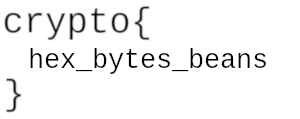

In [ ]:
import requests
from io import BytesIO
from PIL import Image
URL = "http://aes.cryptohack.org/bean_counter/"
xor = lambda x,y: bytes([i^j for i,j in zip(x,y)])
png_header = bytes.fromhex("89504e470d0a1a0a0000000d49484452")
enc_png = bytes.fromhex(requests.get(f"{URL}/encrypt").json()['encrypted'])
key = xor(png_header, enc_png[:len(png_header)])
flag_png = xor(enc_png, key * ( len(enc_png) // len(key) ))
Image.open(BytesIO(flag_png))